In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ethancratchley/email-phishing-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/email-phishing-dataset


📊 Dataset loaded: 524846 rows × 9 columns

📋 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524846 entries, 0 to 524845
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   num_words            524846 non-null  int64
 1   num_unique_words     524846 non-null  int64
 2   num_stopwords        524846 non-null  int64
 3   num_links            524846 non-null  int64
 4   num_unique_domains   524846 non-null  int64
 5   num_email_addresses  524846 non-null  int64
 6   num_spelling_errors  524846 non-null  int64
 7   num_urgent_keywords  524846 non-null  int64
 8   label                524846 non-null  int64
dtypes: int64(9)
memory usage: 36.0 MB
None

🔍 Missing Values:
Series([], dtype: int64)

🔍 Duplicate Rows:
319794

📈 Skewness Check:
num_stopwords          664.824899
num_words              657.793881
num_spelling_errors    485.379589
num_unique_domains      70.274777
num_unique_words        4

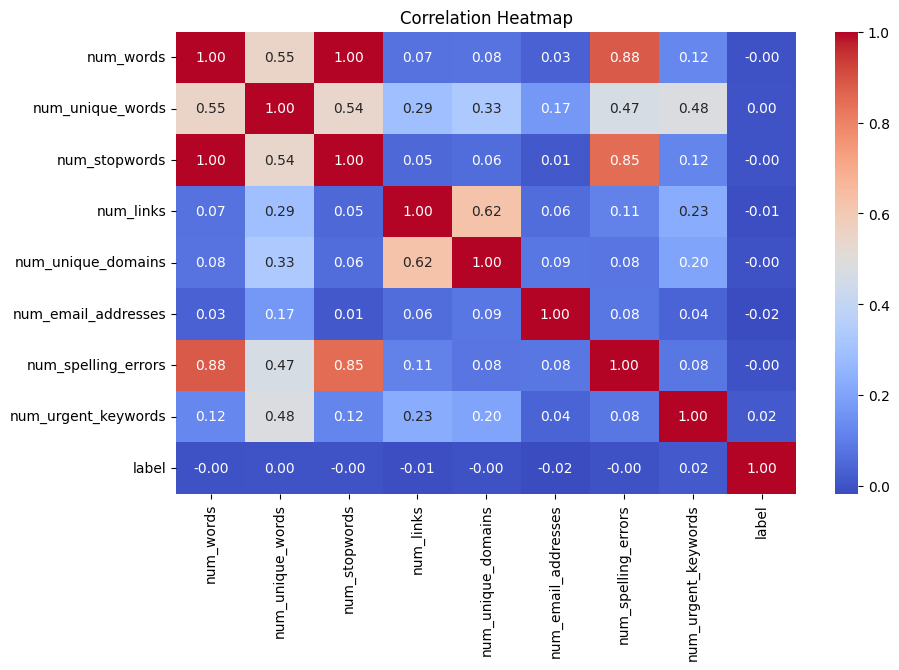

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ====== 1. Load Data ======
df = pd.read_csv("/kaggle/input/email-phishing-dataset/email_phishing_data.csv")  # Ganti dengan nama file kamu
print(f"📊 Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

# ====== 2. Basic Info ======
print("\n📋 Basic Info:")
print(df.info())

# ====== 3. Missing Values & Duplicate Rows Check ======
print("\n🔍 Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

print("\n🔍 Duplicate Rows:")
duplicate = df.duplicated().sum()
print(duplicate)

# ====== 4. Skewness Check ======
print("\n📈 Skewness Check:")
skewed_features = df.select_dtypes(include=['number']).apply(lambda x: x.skew()).sort_values(ascending=False)
print(skewed_features)

print("\n📌 Recommendation:")
for col, skew in skewed_features.items():
    if abs(skew) > 1:
        print(f"⚠️ {col} is highly skewed (skew={skew:.2f}). Suggest: Apply log or sqrt transform.")
    elif abs(skew) > 0.5:
        print(f"ℹ️ {col} is moderately skewed (skew={skew:.2f}). Transform optional.")
    else:
        print(f"✅ {col} is fairly symmetric (skew={skew:.2f}). No action needed.")

# ====== 5. Outlier Detection (IQR Method) ======
print("\n📦 Outlier Check (IQR Method):")
for col in df.select_dtypes(include=['number']):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    if outlier_count > 0:
        print(f"⚠️ {col}: {outlier_count} outliers detected.")
    else:
        print(f"✅ {col}: No significant outliers.")

# ====== 6. Correlation Analysis ======
print("\n🔗 Correlation Matrix (Top correlated pairs):")
correlation = df.corr(numeric_only=True)
cor_matrix = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_corr = cor_matrix[(cor_matrix < 1) & (cor_matrix > 0.7)]
print(top_corr)

print("\n📌 Recommendation:")
for (f1, f2), corr_val in top_corr.items():
    print(f"⚠️ {f1} & {f2} have high correlation ({corr_val:.2f}). Suggest: Keep only one or apply dimensionality reduction (e.g., PCA).")

# ====== 7. Heatmap ======
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [3]:
df.head()

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
0,140,94,52,0,0,0,0,0,0
1,5,5,1,0,0,0,0,0,0
2,34,32,15,0,0,0,0,0,0
3,6,6,2,0,0,0,0,0,0
4,9,9,2,0,0,0,0,0,0


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# === Step 1: Drop Duplicate rows ===
df = df.drop_duplicates()

# === Step 2: Define Features & Target ===
X = df.drop(columns=['label'])
y = df['label']

# === Step 3: Feature Engineering ===
# Drop highly correlated features
X = X.drop(columns=['num_stopwords', 'num_spelling_errors'])

# Skewed features
skewed_features = ['num_words', 'num_unique_words', 'num_links',
                   'num_unique_domains', 'num_email_addresses',
                   'num_urgent_keywords']

# === Step 4: Build Preprocessing Pipeline ===
log_transformer = FunctionTransformer(np.log1p, validate=True)

preprocessor = ColumnTransformer(transformers=[
    ('log', log_transformer, skewed_features),
    ('scale', RobustScaler(), skewed_features)
], remainder='passthrough')  # Pass through other columns

# === Step 5: Build Full Pipeline with XGBoost ===
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ))
])

# === Step 6: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# === Step 7: Train Model ===
model.fit(X_train, y_train)

# === Step 8: Evaluate ===
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Optional: Cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f'Cross-validated Accuracy: {scores.mean():.4f} ± {scores.std():.4f}')


              precision    recall  f1-score   support

           0       0.97      1.00      0.99     39795
           1       0.73      0.01      0.01      1216

    accuracy                           0.97     41011
   macro avg       0.85      0.50      0.50     41011
weighted avg       0.96      0.97      0.96     41011

Cross-validated Accuracy: 0.9696 ± 0.0017


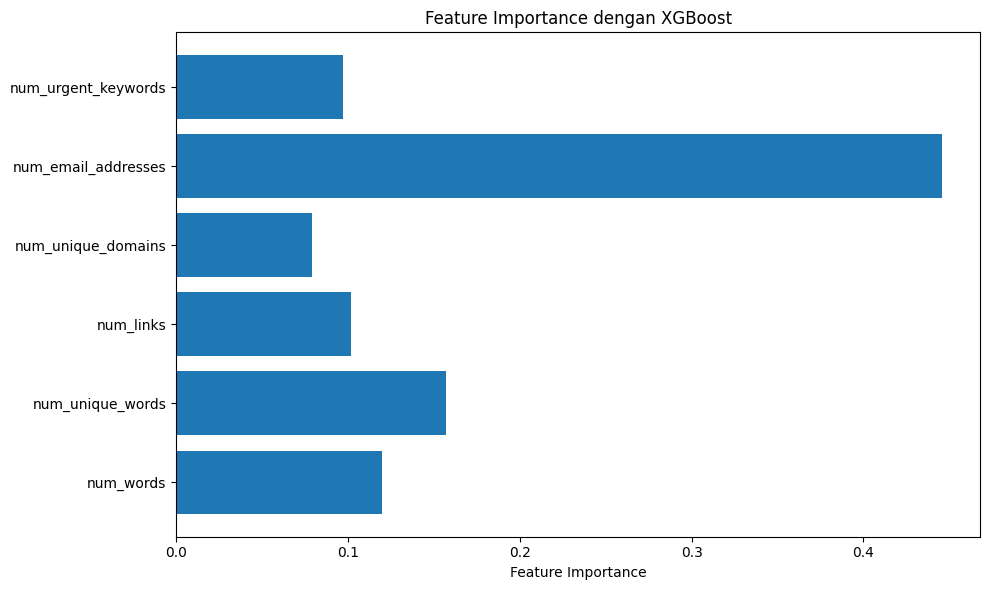

In [7]:
import matplotlib.pyplot as plt

# Step 1: Ambil preprocessor & classifier
preprocessor = model.named_steps['preprocessor']
classifier = model.named_steps['classifier']

# Step 2: Ambil fitur yang ditransformasi
log_scaled_features = preprocessor.transformers_[0][2]  # 'log' + 'scale' kolom
passthrough_features = preprocessor.transformers_[-1][2]  # 'remainder' passthrough kolom

# Gabungkan semua nama fitur
feature_names = log_scaled_features + passthrough_features

# Step 3: Ambil feature importance dari classifier
importances = classifier.feature_importances_

# Pastikan panjang sama
assert len(importances) == len(feature_names), f"Mismatch: {len(importances)} importances vs {len(feature_names)} names"

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance dengan XGBoost")
plt.tight_layout()
plt.show()
